# Приступая к работе

### Путь к данным

In [1]:
TRAIN_DATASET_PATH = 'data/course_project_train.csv'
TEST_DATASET_PATH = 'data/course_project_test.csv'

### Подключение библиотек

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

# EDA
Разведочный анализ данных

In [4]:
# Копия тренировочного датасета для экспериметов
eda_df = df.copy()

## Обработка пропусков

### Признаки с пропусками

In [5]:
def features_with_missing_values(df):
    # Количество наблюдений в датасете
    observations_count = df.shape[0]
    
    # Найдем все признаки с пропущенными значениями
    cols_with_missing = [ col for col in df.columns if df[col].count() < observations_count ]
    
    # Выведем их
    print(cols_with_missing)

# Признаки с пропусками в тренировоном и тестовом датасете
features_with_missing_values(df)
features_with_missing_values(test)

['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']


Как можно заметить, одни и те же признаки имеют пропущенные значение в тренировочном и тестовом датасете

### Корреляция признаков

<AxesSubplot:>

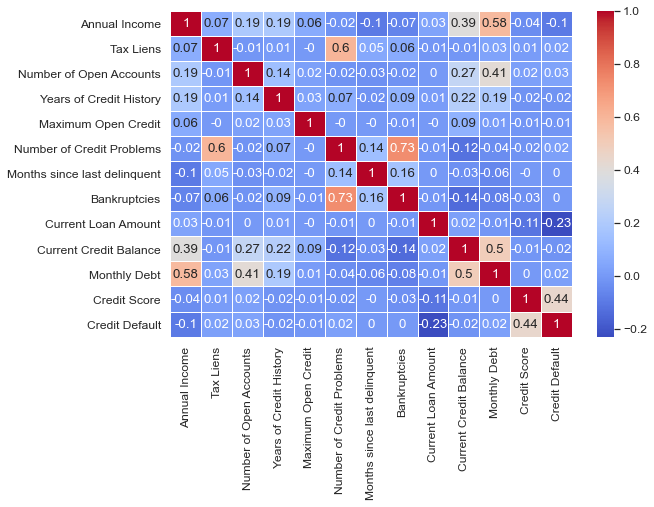

In [6]:
df_corr = np.round(df.corr(), 2)

plt.figure(figsize = (9,6))
sns.set(font_scale=1.1)
sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='coolwarm')

Так как Annual Income коррелирует с Monthly Debt, его пропущенные значения можно заполнить через Montly Debt. То же самое касается Bankruptcies и Number of Credit Problems

In [7]:
eda_df["Annual Income"].fillna(eda_df["Monthly Debt"], inplace=True)
eda_df["Bankruptcies"].fillna(eda_df["Number of Credit Problems"], inplace=True)

### Распределение кредитного рейтинга

<AxesSubplot:xlabel='Credit Default', ylabel='Credit Score'>

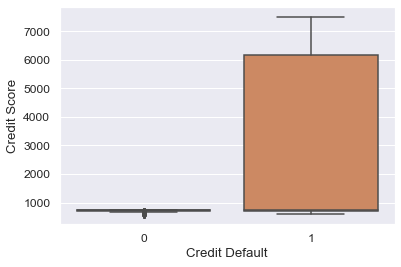

In [8]:
# plt.hist(df["Credit Score"], bins=30)
# plt.scatter(df["Credit Score"], df["Credit Default"])
# plt.show()
sns.boxplot(x=df["Credit Default"], y=df["Credit Score"])

Проверим, есть ли выбросы в Credit Score. Для этого вычислим медианы Credit Score для обоих значение Credit Default

In [9]:
credit_default_median = eda_df.groupby(["Credit Default"])["Credit Score"].agg("median")
credit_default_median

Credit Default
0    732.0
1    730.5
Name: Credit Score, dtype: float64

Как можно заметить, обе медианы очень близки и не уходят в четырех значные числа. Очевидно, выбросы! Давайте заполним значения пропущенные значения в Credit Score этими медианами

In [10]:
eda_df["Credit Score"].fillna(eda_df["Credit Default"].map(credit_default_median), inplace=True)

### Заполняем остальные пропущенные значение

#### Years in current job

In [11]:
eda_df["Years in current job"].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Будем считать, что если данные отсутствуют, клиент банка не работает. Заполним значением '< 1 year'

In [12]:
eda_df["Years in current job"].fillna("< 1 year", inplace=True)

#### Months since last delinquent

Тут я никакой закономерности не нашел. Заполню медианой

In [13]:
eda_df["Months since last delinquent"].fillna( \
    eda_df["Months since last delinquent"].median(), inplace=True)

Убедимся, что больше пропущенных значений нет

In [14]:
features_with_missing_values(eda_df)

[]


## Новые признаки

### Строковые признаки

Выведем все строковые признаки

In [15]:
print([ col for col in eda_df.columns if eda_df[col].dtype == 'O' ])

['Home Ownership', 'Years in current job', 'Purpose', 'Term']


Модели работают только с числовыми признаками. Переведем их в числа

#### Home Ownership

In [16]:
eda_df["Home Ownership"].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

Этот признак не числовой, а категориальный. Лучшая стратегия это перевести его в дамми признаки

In [17]:
home_ownership_dummies = pd.get_dummies(eda_df["Home Ownership"], prefix="Home Ownership")
eda_df = pd.concat([eda_df, home_ownership_dummies], axis=1)

#### Years in current job

In [18]:
eda_df["Years in current job"].unique()

array(['< 1 year', '10+ years', '8 years', '6 years', '7 years',
       '5 years', '1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Этот признак вещественный. Давайте переведем его в числа, заодно укажем оптимальный тип

In [19]:
eda_df["Years in current job"] = eda_df["Years in current job"].map({
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0
    }).astype(np.int8)

#### Purpose

In [20]:
eda_df["Purpose"].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

Это тоже категориальный признак. Заменим его на дамми переменные

In [21]:
purpose_dummies = pd.get_dummies(eda_df["Purpose"], prefix="Purpose")
eda_df = pd.concat([eda_df, purpose_dummies], axis=1)

#### Term

In [22]:
eda_df["Term"].unique()

array(['Short Term', 'Long Term'], dtype=object)

Это бинарный признак. Его можно заменить на числа

In [23]:
eda_df["Is Long Term"] = eda_df["Term"].map({
        'Short Term': 0,
        'Long Term': 1
    }).astype(np.int8)

## Отбор признаков

Мы добавили к строковым признакам их числовые эквиваленты, но строковые признаки все еще остались. Давайте их уберем

In [24]:
str_features = [ col for col in eda_df.columns if eda_df[col].dtype == 'O' ]
eda_df.drop(columns=str_features, inplace=True)

# Предобработка данных

Пока что вместо предобработки возьму в качестве основы eda_df

In [27]:
# Признаки
X = eda_df.drop("Credit Default", axis=1)

# Целевая переменная
y = eda_df["Credit Default"]

# Разделение на тренировочную и валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение

In [29]:
model = GradientBoostingClassifier(criterion='mse',
                                  max_depth=6,
                                  min_samples_leaf=50,
                                  random_state=42,
                                  n_estimators=2250)
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='mse', max_depth=6, min_samples_leaf=50,
                           n_estimators=2250, random_state=42)

# Предсказание

### Оценка качества модели на тренировочной и валидационной выборке

In [35]:
print(f"Тренировочная: {f1_score(y_train, model.predict(X_train))}")
print(f"Валидационная: {f1_score(y_valid, model.predict(X_valid))}")

Тренировочная: 1.0
Валидационная: 0.6421697287839021
